## ELETTRA-07: ID tune shift fit & correction (global tune knob)

In [1]:
# In this example effects of an ID (APPLE-II device represented by a linear 4x4 symplectic matrix) are presented

# Tune shift introduced by ID is first used to fit the ID model
# Next, global tune correction is performed using the fitted model and the correction result is evaluated

In [2]:
# Import

import torch
from torch import Tensor

from pathlib import Path

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
matplotlib.rcParams['text.usetex'] = True

from model.library.element import Element
from model.library.line import Line
from model.library.quadrupole import Quadrupole
from model.library.matrix import Matrix

from model.command.external import load_lattice
from model.command.build import build
from model.command.tune import tune
from model.command.orbit import dispersion
from model.command.twiss import twiss
from model.command.advance import advance
from model.command.coupling import coupling

from model.command.wrapper import Wrapper

In [3]:
# Set data type and device

Element.dtype = dtype = torch.float64
Element.device = device = torch.device('cpu')

In [4]:
# Load lattice (ELEGANT table)
# Note, lattice is allowed to have repeated elements

path = Path('elettra.lte')
data = load_lattice(path)

In [5]:
# Build and setup lattice

ring:Line = build('RING', 'ELEGANT', data)

# Flatten sublines

ring.flatten()

# Remove all marker elements but the ones starting with MLL (long straight section centers)

ring.remove_group(pattern=r'^(?!MLL_).*', kinds=['Marker'])

# Replace all sextupoles with quadrupoles

def factory(element:Element) -> None:
    table = element.serialize
    table.pop('ms', None)
    return Quadrupole(**table)

ring.replace_group(pattern=r'', factory=factory, kinds=['Sextupole'])

# Set linear dipoles

def apply(element:Element) -> None:
    element.linear = True

ring.apply(apply, kinds=['Dipole'])

# Merge drifts

ring.merge()

# Change lattice start

ring.start = "BPM_S01_01"

# Split BPMs

ring.split((None, ['BPM'], None, None))

# Roll lattice

ring.roll(1)

# Splice lattice

ring.splice()

# Describe

ring.describe

{'BPM': 168, 'Drift': 708, 'Dipole': 156, 'Quadrupole': 360, 'Marker': 12}

In [6]:
# Compute tunes (fractional part)

nux, nuy = tune(ring, [], matched=True, limit=1)

In [7]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx, etapx, etaqy, etapy = dispersion(ring, orbit, [], limit=1)

In [8]:
# Compute twiss parameters

ax, bx, ay, by = twiss(ring, [], matched=True, advance=True, full=False).T

In [9]:
# Compute phase advances

mux, muy = advance(ring, [], alignment=False, matched=True).T

In [10]:
# Compute coupling

c = coupling(ring, [])

In [11]:
# Define ID model
# Note, only the flattened triangular part of the A and B matrices is passed

A = torch.tensor([[-0.03484222052711237, 1.0272120741819959E-7, -4.698931299341201E-9, 0.0015923185492594811],
                  [1.0272120579834892E-7, -0.046082787920135176, 0.0017792061173117564, 3.3551298301095784E-8],
                  [-4.6989312853101E-9, 0.0017792061173117072, 0.056853750760983084, -1.5929605363332683E-7],
                  [0.0015923185492594336, 3.3551298348653296E-8, -1.5929605261642905E-7, 0.08311631737263032]], dtype=dtype)

B = torch.tensor([[0.03649353186115209, 0.0015448347221877217, 0.00002719892025520868, -0.0033681183134964482],
                  [0.0015448347221877217, 0.13683886657005795, -0.0033198692682377406, 0.00006140578258682469],
                  [0.00002719892025520868, -0.0033198692682377406, -0.05260095308967722, 0.005019907688182885],
                  [-0.0033681183134964482, 0.00006140578258682469, 0.005019907688182885, -0.2531573249456863]], dtype=dtype)

ID = Matrix('ID', 
            length=0.0, 
            A=A[torch.triu(torch.ones_like(A, dtype=torch.bool))].tolist(), 
            B=B[torch.triu(torch.ones_like(B, dtype=torch.bool))].tolist())

In [12]:
# Insert ID into the existing lattice
# This will replace the target marker

error = ring.clone()
error.flatten()
error.insert(ID, 'MLL_S01', position=0.0)
error.splice()

In [13]:
# Measure tunes with ID

nux_id, nuy_id = target = tune(error, [], matched=True)

print((nux - nux_id).abs())
print((nuy - nuy_id).abs())

tensor(0.0260, dtype=torch.float64)
tensor(0.0114, dtype=torch.float64)


In [14]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx_id, etapx_id, etaqy_id, etapy_id = dispersion(error, orbit, [], limit=1)

In [15]:
# Compute twiss parameters

ax_id, bx_id, ay_id, by_id = twiss(error, [], matched=True, advance=True, full=False).T

In [16]:
# Compute phase advances

mux_id, muy_id = advance(error, [], alignment=False, matched=True).T

In [17]:
# Compute coupling

c_id = coupling(error, [])

In [18]:
# Create a ring with ID to be fitted to measured observables (tunes)

TM = Matrix('TM')

model = ring.clone()
model.flatten()
model.insert(TM, 'MLL_S01', position=0.0)
model.splice()

In [19]:
# Define parametric observable

def observable(knobs):
    a11, a12, a13, a14, a22, a23, a24, a33, a34, a44 = knobs.reshape(-1, 1)
    return tune(model,
                [a11, a12, a13, a14, a22, a23, a24, a33, a34, a44],
                ('a11', None, ['TM'], None),
                ('a12', None, ['TM'], None),
                ('a13', None, ['TM'], None),
                ('a14', None, ['TM'], None),
                ('a22', None, ['TM'], None),
                ('a23', None, ['TM'], None),
                ('a24', None, ['TM'], None),
                ('a33', None, ['TM'], None),
                ('a34', None, ['TM'], None),
                ('a44', None, ['TM'], None), 
                matched=True)

In [20]:
# Test observable with known ID model

print(target)
print(observable(ID.A))

tensor([0.2735, 0.1723], dtype=torch.float64)
tensor([0.2735, 0.1723], dtype=torch.float64)


In [21]:
# Define objective function to be fitted

def objective(knobs):
    return ((target - observable(knobs))**2).sum()

print(objective(0.0*ID.A))
print(objective(1.0*ID.A))

tensor(0.0008, dtype=torch.float64)
tensor(0., dtype=torch.float64)


In [22]:
# Fit (ADAM)

knobs = torch.tensor(10*[0.0], dtype=dtype)

wrapper = Wrapper(objective, knobs)
optimizer = torch.optim.AdamW(wrapper.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=32, gamma=0.95)

for epoch in range(256):
    value = wrapper()
    value.backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step()
    print(value.detach().item())

0.0008048399068028212
0.0007620349342060703
0.0007205307248509358
0.0006803424125036658
0.0006414829893953095
0.000603963179617447
0.0005677915620312731
0.0005329731984290826
0.0004995122939169441
0.0004674085174248959
0.0004366601056032604
0.0004072621312454616
0.0003792063439073972
0.00035248203582205717
0.0003270757300961398
0.0003029708127255459
0.0002801477863792213
0.0002585845600949164
0.00023825635953760388
0.00021913568060475866
0.0002011924927164019
0.00018439447901961084
0.00016870714114430743
0.00015409389745957427
0.00014051628793088745
0.00012793422756922452
0.00011630622031845724
0.00010558955674398206
9.574054947860015e-05
8.67147997185777e-05
7.846745200867355e-05
7.095343221204984e-05
6.412769310437521e-05
5.8244372091230745e-05
5.2910475720096975e-05
4.808632410942108e-05
4.373340605244055e-05
3.981449880451027e-05
3.6293785401960895e-05
3.3136958575082696e-05
3.031130622646868e-05
2.778578191273694e-05
2.553106407645505e-05
2.351960251849228e-05
2.1725647947110543e-

In [23]:
# Fit (LBFGS)

knobs = torch.tensor(10*[0.0], dtype=dtype, requires_grad=True)
optimizer = torch.optim.LBFGS([knobs], lr=0.1, line_search_fn="strong_wolfe")

def closure():
    optimizer.zero_grad()
    value = objective(knobs)
    value.backward()
    return value

for epoch in range(8):
    value = optimizer.step(closure)
    print(value.item())

0.0008048399068028212
6.976747029574662e-11
6.976747029574662e-11
6.976747029574662e-11
6.976747029574662e-11
6.976747029574662e-11
6.976747029574662e-11
6.976747029574662e-11


In [24]:
# Check fitted tunes

print(target)
print(observable(ID.A))
print(observable(knobs.detach()))
print()

print((target - observable(ID.A)).abs())
print((target - observable(knobs.detach())).abs())

tensor([0.2735, 0.1723], dtype=torch.float64)
tensor([0.2735, 0.1723], dtype=torch.float64)
tensor([0.2735, 0.1723], dtype=torch.float64)

tensor([0., 0.], dtype=torch.float64)
tensor([6.7254e-07, 8.3256e-06], dtype=torch.float64)


In [25]:
# Define fitted model

TM.A = knobs.detach()

print(target)
print(tune(model, [], matched=True, limit=1))

tensor([0.2735, 0.1723], dtype=torch.float64)
tensor([0.2735, 0.1723], dtype=torch.float64)


In [26]:
# Define target tunes 

target = tune(ring, [], matched=True, limit=1)
print(target)

tensor([0.2994, 0.1608], dtype=torch.float64)


In [27]:
# Define parametric observable

QF = [f'QF_S{i:02}_{j:02}' for j in [2, 3] for i in range(1, 12 + 1)]
QD = [f'QD_S{i:02}_{j:02}' for j in [2, 3] for i in range(1, 12 + 1)]

def observable(kn):
    return tune(model, [kn], ('kn', None, QF + QD, None), matched=True, limit=1)

knobs = torch.zeros(len(QF + QD), dtype=dtype)
print(observable(knobs))

tensor([0.2735, 0.1723], dtype=torch.float64)


In [28]:
# Define objective

def objective(knobs):
    return ((target - observable(knobs))**2).sum()

print(objective(knobs))

tensor(0.0008, dtype=torch.float64)


In [29]:
# Fit 

knobs = torch.tensor(len(QF + QD)*[0.0], dtype=dtype, requires_grad=True)
optimizer = torch.optim.LBFGS([knobs], lr=0.1, line_search_fn="strong_wolfe")

def closure():
    optimizer.zero_grad()
    value = objective(knobs)
    value.backward()
    return value

for epoch in range(8):
    value = optimizer.step(closure)
    print(value.item())

0.0008049953927670922
4.915507721072069e-12
4.915507721072069e-12
4.915507721072069e-12
4.915507721072069e-12
4.915507721072069e-12
4.915507721072069e-12
4.915507721072069e-12


In [30]:
# Apply corrections to model with the exact ID

result = error.clone()
result.flatten()
for name, knob in zip(QF + QD, knobs.detach()):
    result[name].kn = (result[name].kn + knob).item()
result.splice()

In [31]:
# Compute tunes (fractional part)

nux_result, nuy_result = tune(result, [], matched=True, limit=1)

In [32]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx_result, etapx_result, etaqy_result, etapy_result = dispersion(result, orbit, [], limit=1)

In [33]:
# Compute twiss parameters

ax_result, bx_result, ay_result, by_result = twiss(result, [], matched=True, advance=True, full=False).T

In [34]:
# Compute phase advances

mux_result, muy_result = advance(result, [], alignment=False, matched=True).T

In [35]:
# Compute coupling

c_result = coupling(result, [])

In [36]:
# Tune shifts

print((nux - nux_id).abs())
print((nuy - nuy_id).abs())
print()

print((nux - nux_result).abs())
print((nuy - nuy_result).abs())
print()

tensor(0.0260, dtype=torch.float64)
tensor(0.0114, dtype=torch.float64)

tensor(0.0001, dtype=torch.float64)
tensor(0.0001, dtype=torch.float64)



In [37]:
# Coupling (minimal tune distance)

print(c)
print(c_id)
print(c_result)

tensor(0., dtype=torch.float64)
tensor(0.0004, dtype=torch.float64)
tensor(0.0003, dtype=torch.float64)


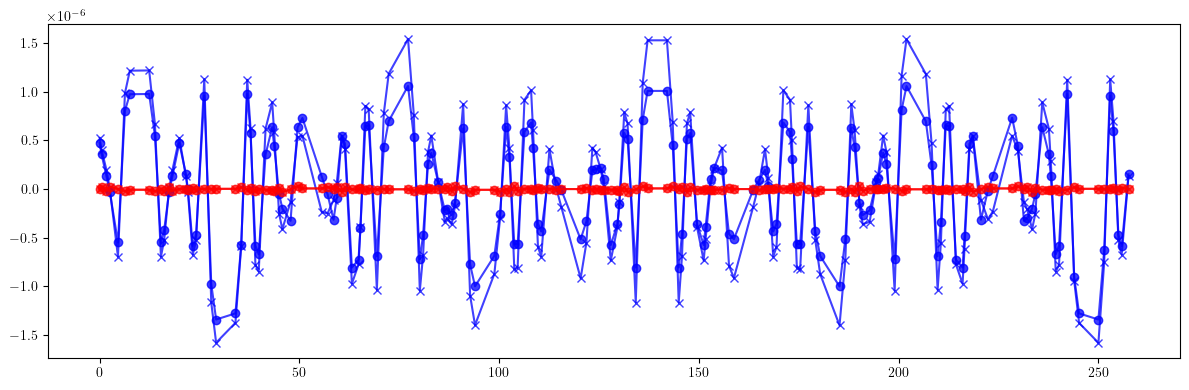

tensor(7.4928e-07, dtype=torch.float64) tensor(3.1227e-06, dtype=torch.float64)
tensor(1.4168e-08, dtype=torch.float64) tensor(6.0573e-08, dtype=torch.float64)

tensor(5.7138e-07, dtype=torch.float64) tensor(2.4011e-06, dtype=torch.float64)
tensor(1.4374e-08, dtype=torch.float64) tensor(6.1571e-08, dtype=torch.float64)



In [38]:
# Dispersion

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_id).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_id).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_result).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_result).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)

plt.tight_layout()
plt.show()

print(((etaqx - etaqx_id)**2).mean().sqrt(), (etaqx - etaqx_id).max() - (etaqx - etaqx_id).min())
print(((etaqy - etaqy_id)**2).mean().sqrt(), (etaqy - etaqy_id).max() - (etaqy - etaqy_id).min())
print()

print(((etaqx - etaqx_result)**2).mean().sqrt(), (etaqx - etaqx_result).max() - (etaqx - etaqx_result).min())
print(((etaqy - etaqy_result)**2).mean().sqrt(), (etaqy - etaqy_result).max() - (etaqy - etaqy_result).min())
print()

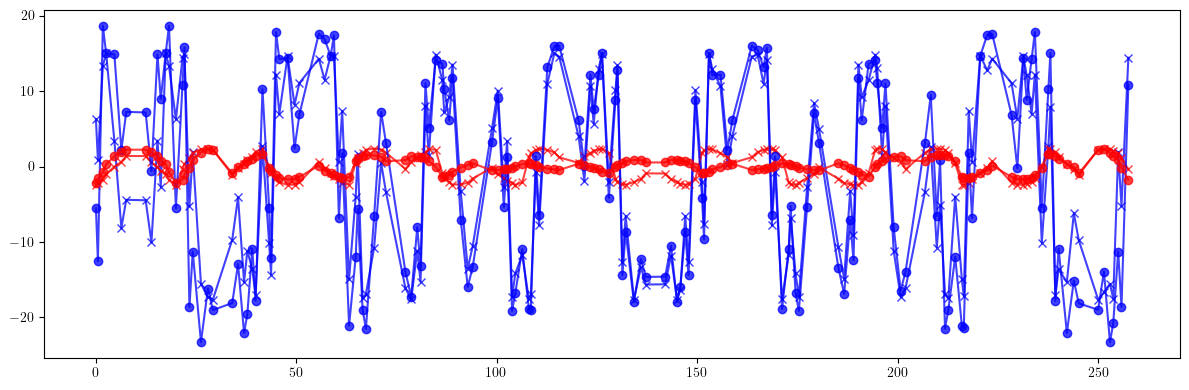

tensor(11.5994, dtype=torch.float64) tensor(32.6569, dtype=torch.float64)
tensor(1.7916, dtype=torch.float64) tensor(4.8154, dtype=torch.float64)

tensor(13.2856, dtype=torch.float64) tensor(41.9470, dtype=torch.float64)
tensor(1.0639, dtype=torch.float64) tensor(4.4647, dtype=torch.float64)



In [39]:
# Beta-beating

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_id)/bx).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_id)/by).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_result)/bx).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_result)/by).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt(), 100*(((bx - bx_id)/bx).max() - ((bx - bx_id)/bx).min()))
print(100*(((by - by_id)/by)**2).mean().sqrt(), 100*(((by - by_id)/by).max() - ((by - by_id)/by).min()))
print()

print(100*(((bx - bx_result)/bx)**2).mean().sqrt(), 100*(((bx - bx_result)/bx).max() - ((bx - bx_result)/bx).min()))
print(100*(((by - by_result)/by)**2).mean().sqrt(), 100*(((by - by_result)/by).max() - ((by - by_result)/by).min()))
print()

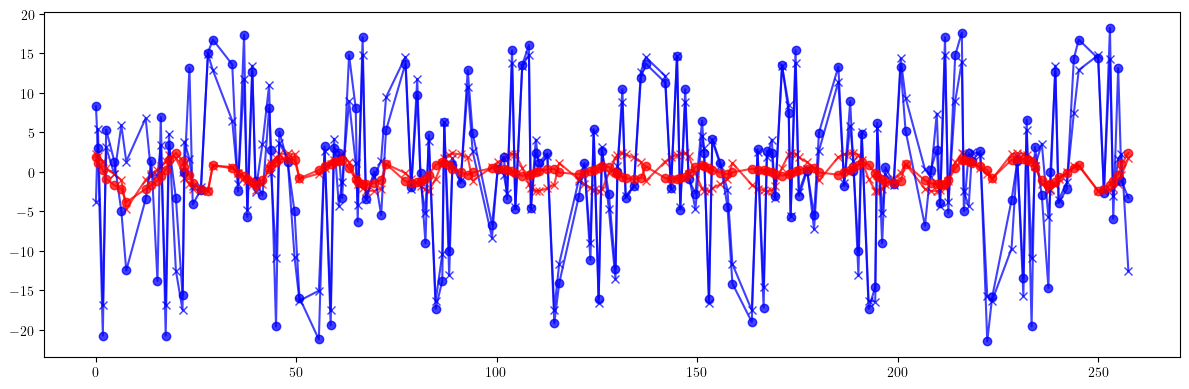

tensor(8.7941, dtype=torch.float64) tensor(32.4432, dtype=torch.float64)
tensor(1.7778, dtype=torch.float64) tensor(7.0609, dtype=torch.float64)

tensor(9.8962, dtype=torch.float64) tensor(39.6465, dtype=torch.float64)
tensor(1.0777, dtype=torch.float64) tensor(6.2230, dtype=torch.float64)



In [40]:
# Phase advance

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((mux - mux_id)/mux).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((muy - muy_id)/muy).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((mux - mux_result)/mux).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((muy - muy_result)/muy).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((mux - mux_id)/mux)**2).mean().sqrt(), 100*(((mux - mux_id)/mux).max() - ((mux - mux_id)/mux).min()))
print(100*(((muy - muy_id)/muy)**2).mean().sqrt(), 100*(((muy - muy_id)/muy).max() - ((muy - muy_id)/muy).min()))
print()

print(100*(((mux - mux_result)/mux)**2).mean().sqrt(), 100*(((mux - mux_result)/mux).max() - ((mux - mux_result)/mux).min()))
print(100*(((muy - muy_result)/muy)**2).mean().sqrt(), 100*(((muy - muy_result)/muy).max() - ((muy - muy_result)/muy).min()))
print()